# Radial Basis Function Neural Network
#### Mehdi Lotfipour

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from matplotlib.gridspec import GridSpec

First we define mathematical functions.

In [21]:
def net_maker(X, Centers):
    #X: (d x 1 x N)tensor -> d: input dimension & N: number of records
    #Centers: (d x h x 1)vector -> d: input dimension & h: hidden layer dimension
    #net_maker(X, Centers): (h x N)matrix
    net = (X - Centers) ** 2
    net = np.einsum('ijk->jk', net)
    return net

def gauss(Net, Sigmas):
    #Net: (h x N)matrix -> h: hidden layer dimension & N: number of records
    #Sigmas: (h x 1)vector -> h: hidden layer dimension
    #gauss(Net, Sigmas): (h x N)matrix
    z = -0.5 * (Net / Sigmas) ** 2
    return np.exp(z)

def softmax(X):
    #X: (d x N)matrix -> d: input dimension & N: number of records
    #softmax(X): (m x N)matrix -> m: output dimension & N: number of records
    z_nom = np.exp(X)
    z_denom = np.einsum('ij->j', z_nom)
    return z_nom / z_denom

def softmax_der(X):
    #X: (d x N)matrix -> d: input dimension & N: number of records
    #softmax_der(X): (m x m x N)tensor -> m: output dimension & N: number of records
    s = softmax(X)
    record_dim = s.shape[0]
    record_len = s.shape[1]
    a = np.zeros([record_dim, record_dim, record_len])
    a[np.arange(record_dim), np.arange(record_dim), :] = s
    b = np.einsum('ik,jk->ijk', s,s)
    return a - b

Here we define a class to keep our radial basis function neural network. The network is defined by its "layer sizes" and its initial "centers" and "sigmas". It has two function of "feed forward" and "back propagation". "feed forward" function takes an input matrix and changes layer variables of network. "back propagation" function takes a target matrix and calculate network parameter changes w.r.t last "input matrix" and "target matrix"

After that we define a "fit" function. It takes a "network", training dataset concluding "training input" and "training target" and "epochs". this function makes the network to fit on the training dataset and return epoch details in a dictionary.

Last function is "k-mean" algorithm. It takes a dataset and return k centers in that space which minimizes its distortion. "k-mean" is an unsupervised learning algorithm, that means no need for target labels.

In [22]:
class RBF_NN():
#class of a radial basis function neural network

    def __init__(self, d, h, m, C, S, eta):
    #initial network
        #d: input dimension
        self.d = d
        #h: hidden layer dimension
        self.h = h
        #m: output layer dimension
        self.m = m
        #C: matrix of initial basis function centers (d x h)
        self.Centers = C
        #S: vector of initial basis function sigmas (m x 1)
        self.Sigmas = S
        #eta: learning rate
        self.eta = eta
        #random initial weight matrix of "W" (m x h)
        self.W = np.random.rand(self.m, self.h)
        #zero initial bias vector of "B" (m x 1)
        self.B = np.zeros([self.m, 1])
    
    def feed_fwd(self, input_matrix):
    #perform feed forward algorithm on "input_matrix"
        #keeping matrix of input in "X"
        self.X = input_matrix.copy()
        #Net = net_maker(X, Centers)
        self.Net = net_maker(self.X.reshape(self.d,1,-1), self.Centers.reshape(self.d, self.h, 1))
        #Phi = gauss(Net, Sigmas)
        self.Phi = gauss(self.Net, self.Sigmas)
        #Y = B + (W dot Phi)
        self.Y = np.dot(self.W, self.Phi) + self.B
        #Output = softmax(Y)
        self.Output = softmax(self.Y)
        
    def back_prog(self, target_matrix):
    #perform back propagation algorithm based on "target_matrix"
        #Error = Target - Output
        self.Error = target_matrix - self.Output
        #rond(Output)/rond(Y) = softmax'(Y)
        self.dOutput_dY = softmax_der(self.Y)
        #rond(Loss)/rond(Y) = rond(Loss)/rond(Output) * rond(Output)/rond(Y)
        self.dLoss_dY = np.einsum('ijk,jk->ik', self.dOutput_dY, self.Error)
        #rond(Y)/rond(Phi) = W
        self.dY_dPhi = self.W.copy()
        #rond(Loss)/rond(Phi) = rond(Loss)/rond(Y) * rond(Y)/rond(Phi)
        self.dLoss_dPhi = np.einsum('ij,ik->kj', self.dLoss_dY, self.dY_dPhi)
        #rond(Phi)/rond(Sigmas) = Phi * Net^(2) * Sigmas^(-3)
        self.dPhi_dSigmas = self.Phi * (self.Net ** 2) * (self.Sigmas ** -3)
        #rond(Phi)/rond(Net) = Phi * (-)Net * Sigmas^(-2)
        self.dPhi_dNet = self.Phi * (-self.Net) * (self.Sigmas ** -2)
        #rond(Net)/rond(Centers) = -2 * (X - Centers)
        self.dNet_dCenters = -2 * (self.X.reshape(self.d,1,-1) - self.Centers.reshape(self.d,self.h,-1))
        #rond(Y)/rond(W) = Phi
        self.dY_dW = self.Phi
        
        #change of network parameters
        #delta_W = rond(Loss)/rond(Y) * rond(Y)/rond(W)
        self.change_W = np.einsum('ik,jk->ij', self.dLoss_dY, self.dY_dW)
        #delta_B = rond(Loss)/rond(Y)
        self.change_B = np.einsum('ij->i', self.dLoss_dY).reshape(self.m, 1)
        #delta_Sigmas = rond(Loss)/rond(Phi) * rond(Phi)/rond(Sigmas)
        z = self.dLoss_dPhi * self.dPhi_dSigmas
        self.change_Sigmas = np.einsum('ij->i', z).reshape(self.h, 1)
        #delta_Centers = rond(Loss)/rond(Phi) * rond(Phi)/rond(Net) * rond(Net)/rond(Centers)
        z = self.dLoss_dPhi * self.dPhi_dNet
        z = z * self.dNet_dCenters
        self.change_Centers = np.einsum('ijk->ij', z)
        
        #updating network parameters w.r.t learning rate
        self.W += self.eta * self.change_W
        self.B += self.eta * self.change_B
        self.Centers += self.eta * self.change_Centers
        self.Sigmas += self.eta * self.change_Sigmas
        
def fit(network, X_train, Y_train, epoch_size, X_valid= None, Y_valid= None, valid= False):
    #perform feed forward and back propagation in "network" RBF_NN
    #on input matrix of "X_train" and target matrix of "Y_train"
    #for "epoch_size" number of iteration
    #returns dictionary of result which has all iteration details {loss, accuracy value and confusion matrix}
    #this function perform only feed forward
    #and returns result of validation dataset("X_valid", "Y_valid")  if "valid" is true 
    
    #keep detail for each iteration
    loss_train, loss_valid = [], []
    accuracy_train, accuracy_valid = [], []
    #keep confusion matrix of trained network
    cm_train, cm_valid = 0, 0
    
    #repeat algorithm for number of iteration
    for epoch in range(epoch_size):
        #loss and accuracy of validation dataset
        if valid:
            #feed forward
            network.feed_fwd(X_valid)
            #number of correct classified record
            z = (np.argmax(network.Output, axis= 0) == np.argmax(Y_valid, axis= 0))
            #accuracy = (number of correct classified record) / N
            acc = sum(z) / Y_valid.shape[1]
            #Loss = (sum of all N record loss) / N
            loss = np.sum((network.Output - Y_valid) ** 2) / Y_valid.shape[1]
            #keeping details
            loss_valid.append(loss)
            accuracy_valid.append(acc)
        
        #training on training dataset
        #feed forward
        network.feed_fwd(X_train)
        #back propagation
        network.back_prog(Y_train)
        
        #loss and accuracy of training dataset
        #number of correct classified record
        z = (np.argmax(network.Output, axis= 0) == np.argmax(Y_train, axis= 0))
        #accuracy = (number of correct classified record) / N
        acc = sum(z) / Y_train.shape[1]
        #Loss = (sum of all N record loss) / N
        loss = np.sum((network.Output - Y_train) ** 2) / Y_train.shape[1]
        #keeping details
        loss_train.append(loss)
        accuracy_train.append(acc)
    
    #confusion matrix of validation dataset in final state of network
    if valid:
        network.feed_fwd(X_valid)
        target = np.argmax(Y_valid, axis= 0)
        output = np.argmax(network.Output, axis= 0)
        cm_valid = confusion_matrix(target, output)
    
    #confusion matrix of training dataset in final state of network
    network.feed_fwd(X_train)
    target = np.argmax(Y_train, axis= 0)
    output = np.argmax(network.Output, axis= 0)
    cm_train = confusion_matrix(target, output)
    
    #putting (Loss of each iteration), (accuracy of each iteration)
    #and (confusion matrix of trained network) in one "result" dictionary
    result = {'loss_train': loss_train, 'loss_valid': loss_valid,
              'accuracy_train': accuracy_train, 'accuracy_valid': accuracy_valid,
              'confusion_train': cm_train, 'confusion_valid': cm_valid}
    return result

def k_mean(X, k, max_iteration):
    #perform k-mean algorithm
    #on input matirx of "X"
    #and k value of "k"
    #for "max_iteration" number of iteration
    #returns final distortion and final centers
    
    #d is record's dimension
    d = X.shape[0]
    #picking k random record for initial centers
    index = random.sample(range(X.shape[1]), k)
    centers = X[:,index]
    #repeat algorithm for number of iteration
    for iteration in range(max_iteration):
        #result of new clustering
        differ_tensor = X.reshape(d,1,-1) - centers.reshape(d,k,1)
        Z = np.einsum('ijk->jk', differ_tensor ** 2)
        result = np.argmin(Z, axis=0)
        #distortion of new clustering
        distortion = differ_tensor[:,result[range(Z.shape[1])],range(Z.shape[1])]
        distortion = np.sum(distortion ** 2)
        #setting new centers
        for i in range(centers.shape[1]):
            centers[:, i] = np.average(X[:, result == i], axis= 1)
    return distortion, centers

We first import the given dataset. Then we make a one-hot label based on its target. We keep 50% of datas for last part testing. We train on 50% of data with 4-fold method.

In [23]:
#importing given dataset
given_dataset = pd.read_excel('Data/dataset.xlsx')
given_dataset = np.array(given_dataset)
#shuffling data
np.random.shuffle(given_dataset)
#making one-hot structure
target = np.zeros([given_dataset.shape[0], len(np.unique(given_dataset[:, -1]))])
for record in range(given_dataset.shape[0]):
    if given_dataset[record, -1] == 'Bufonidae':
        target[record, 0] = 1
    elif given_dataset[record, -1] == 'Dendrobatidae':
        target[record, 1] = 1
    elif given_dataset[record, -1] == 'Hylidae':
        target[record, 2] = 1
    elif given_dataset[record, -1] == 'Leptodactylidae':
        target[record, 3] = 1
#removing last column of given dataset
#we already changed it to one-hot
#changing all cells type to float64
given_dataset = given_dataset[:, :-1].astype('float64')
#keeping 50% of datas for last test
#we do not use test data during learning
split_ratio = 0.5
n = int(given_dataset.shape[0] * split_ratio)
X_train = given_dataset[:n]
Y_train = target[:n]
X_test = given_dataset[n:]
Y_test = target[n:]
#transposing all datas
#we wants records in columns, not in rows
X_train = X_train.T
Y_train = Y_train.T
X_test = X_test.T
Y_test = Y_test.T
#deviding train data to 4 fold
X_train_k = [0] * 4
Y_train_k = [0] * 4
X_valid_k = [0] * 4
Y_valid_k = [0] * 4
k_X = np.array_split(X_train, 4 , axis= 1)
k_Y = np.array_split(Y_train, 4 , axis= 1)
#fold1
X_train_k[0] = np.concatenate((k_X[1], k_X[2], k_X[3]), axis= 1)
Y_train_k[0] = np.concatenate((k_Y[1], k_Y[2], k_Y[3]), axis= 1)
X_valid_k[0] = k_X[0]
Y_valid_k[0] = k_Y[0]
#fold2
X_train_k[1] = np.concatenate((k_X[0], k_X[2], k_X[3]), axis= 1)
Y_train_k[1] = np.concatenate((k_Y[0], k_Y[2], k_Y[3]), axis= 1)
X_valid_k[1] = k_X[1]
Y_valid_k[1] = k_Y[1]
#fold3
X_train_k[2] = np.concatenate((k_X[0], k_X[1], k_X[3]), axis= 1)
Y_train_k[2] = np.concatenate((k_Y[0], k_Y[1], k_Y[3]), axis= 1)
X_valid_k[2] = k_X[2]
Y_valid_k[2] = k_Y[2]
#fold4
X_train_k[3] = np.concatenate((k_X[0], k_X[1], k_X[2]), axis= 1)
Y_train_k[3] = np.concatenate((k_Y[0], k_Y[1], k_Y[2]), axis= 1)
X_valid_k[3] = k_X[3]
Y_valid_k[3] = k_Y[3]

### Part a.
We define 12 different conditions to choose best one for final product. We choose parameters from:

"number of kernels" between {20, 50, 100}

"initial sigmas" between {0.5, 1, 2}

"learning rate" between {0.001, 0.0001, 0.00001}

"epochs" between {100, 200, 400}

In [26]:
#setting different conditions for compare
conditions = [[20, 1, 0.0001, 200], [50, 1, 0.0001, 200], [100, 1, 0.0001, 200],
              [50, 0.5, 0.0001, 200], [50, 1, 0.0001, 200], [50, 2, 0.0001, 200],
              [50, 1, 0.001, 200], [50, 1, 0.0001, 200], [50, 1, 0.00001, 200],
              [50, 1, 0.0001, 100], [50, 1, 0.0001, 200], [50, 1, 0.0001, 400]]
#iterating through different conditions
#keep result of each condition in "condition_result"
condition_result = []
for i, condition in enumerate(conditions):
    #keep result of each fold in "k_result"
    k_result = []
    #iterating 4 times for each fold
    for k in range(4):
        #selecting random initial centers
        index = random.sample(range(X_train_k[k].shape[1]), condition[0])
        cen = X_train_k[k][:, index]
        #defining initial sigmas
        sig = np.ones([condition[0], 1]) * condition[1]
        #defining network
        saeid = RBF_NN(d= X_train_k[k].shape[0], h= condition[0] ,m= Y_train_k[k].shape[0],
                    C= cen, S= sig, eta= condition[2])
        #fitting on k'th fold
        result = fit(saeid, X_train_k[k], Y_train_k[k], condition[3], X_valid_k[k], Y_valid_k[k], valid= True)
        #adding "result" to "k_result"
        k_result.append(result)
    #adding "k_result" to "condition_result"
    condition_result.append(k_result)

Now we show result of each condition in one row. Left side is plot of training data and right side is plot of validation data.

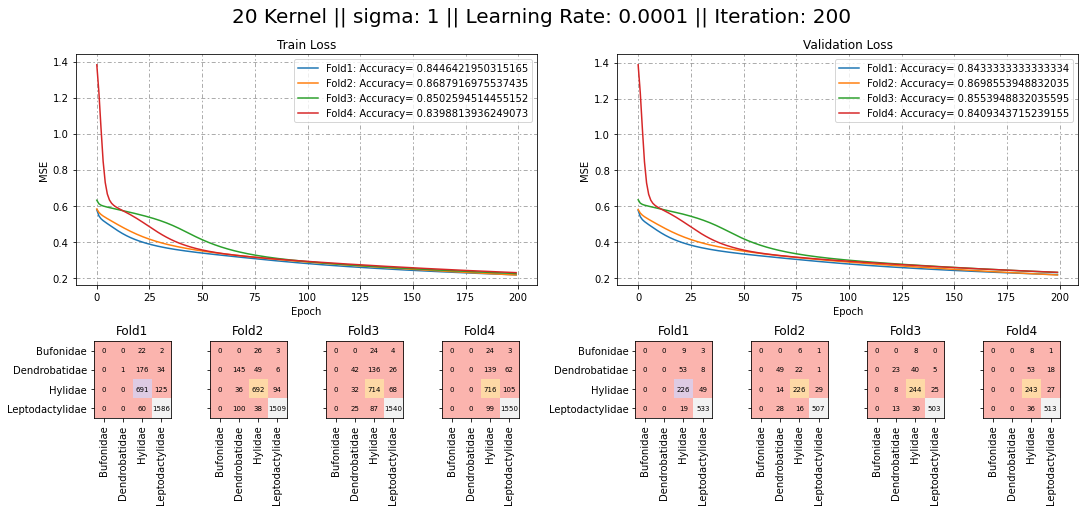

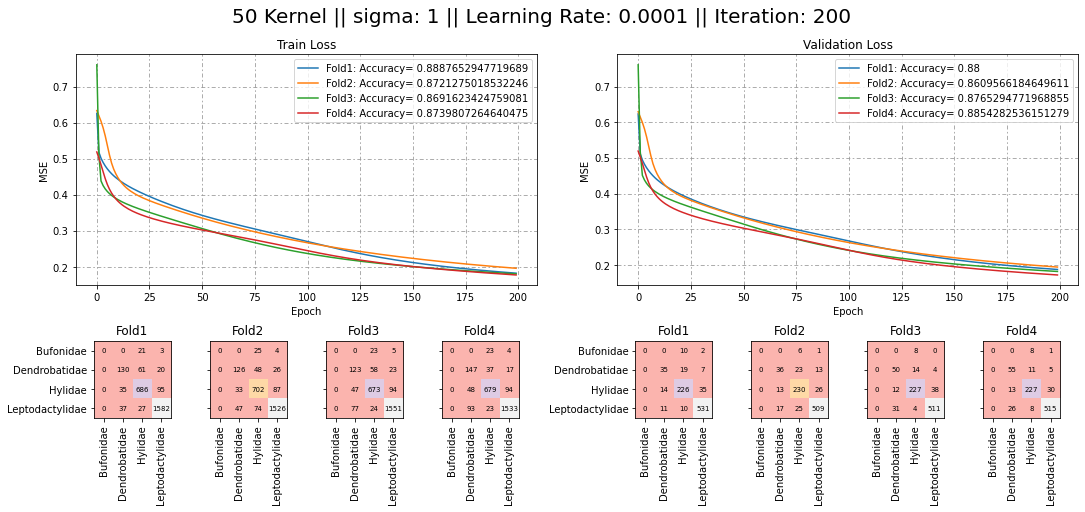

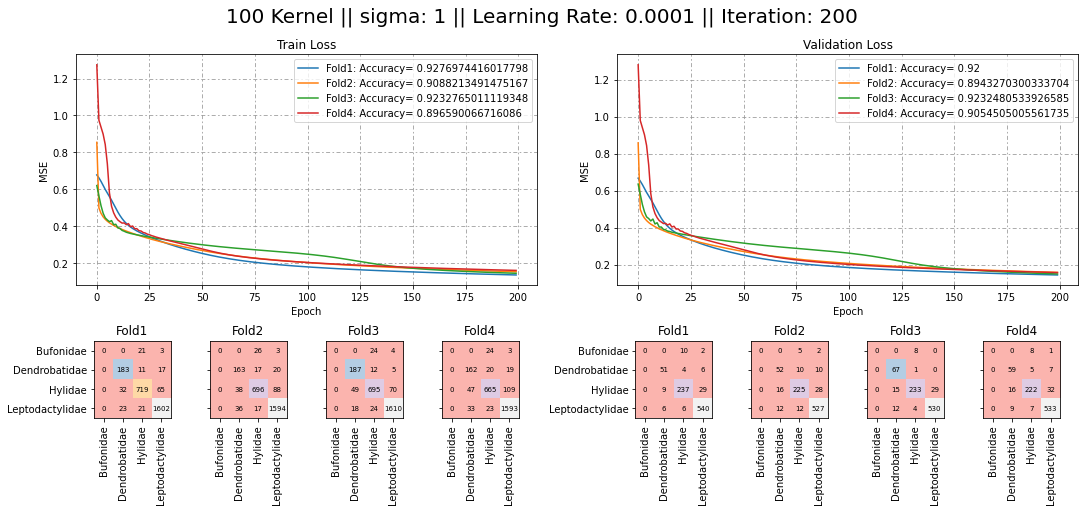

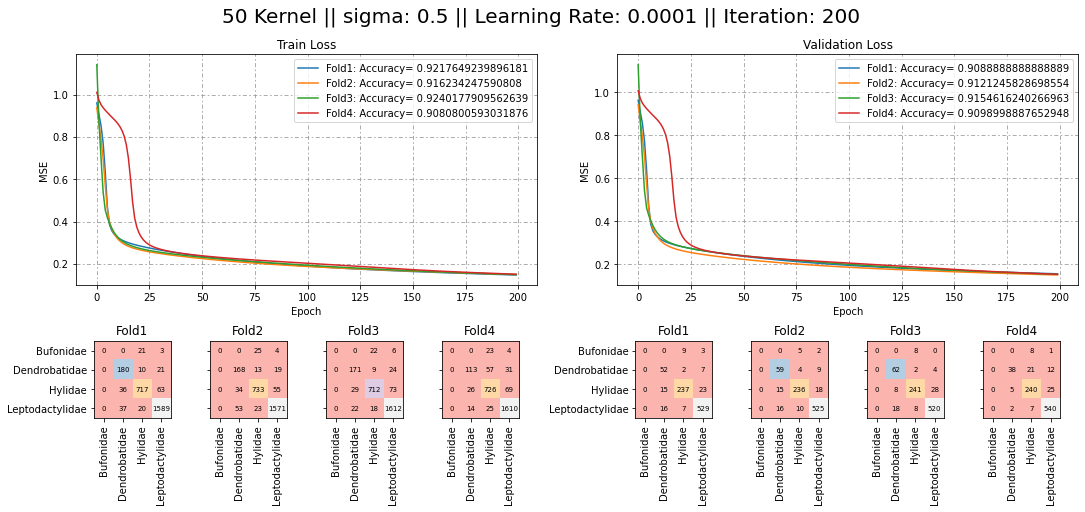

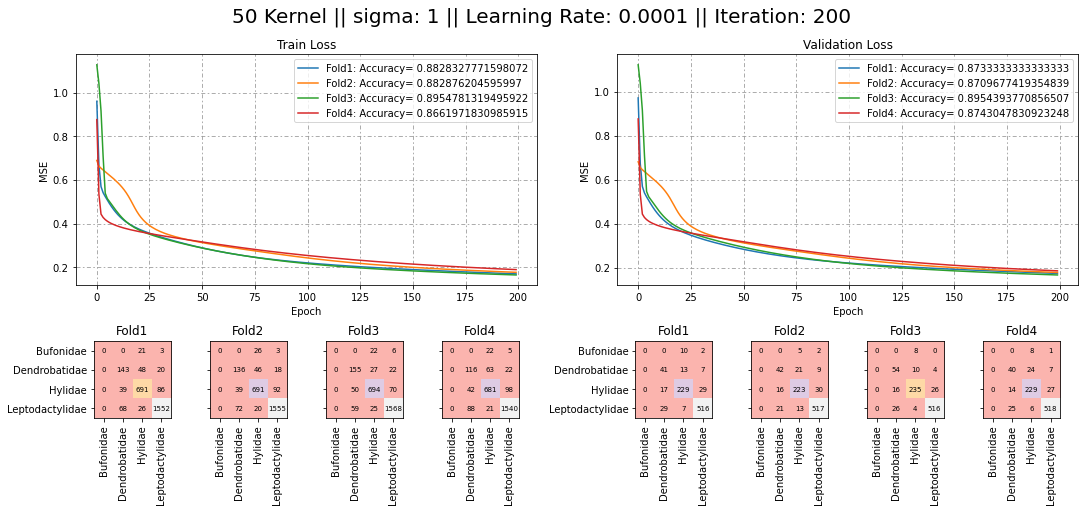

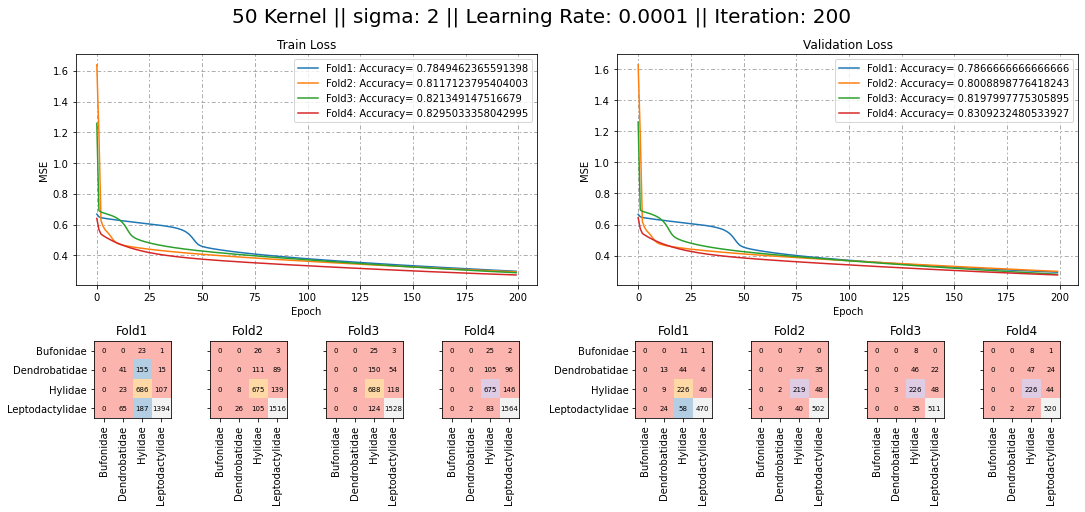

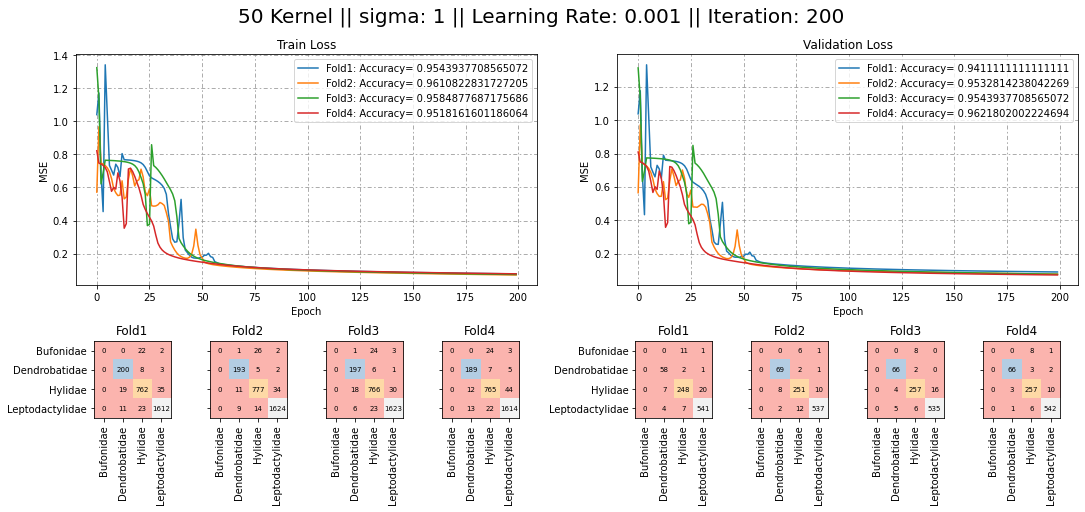

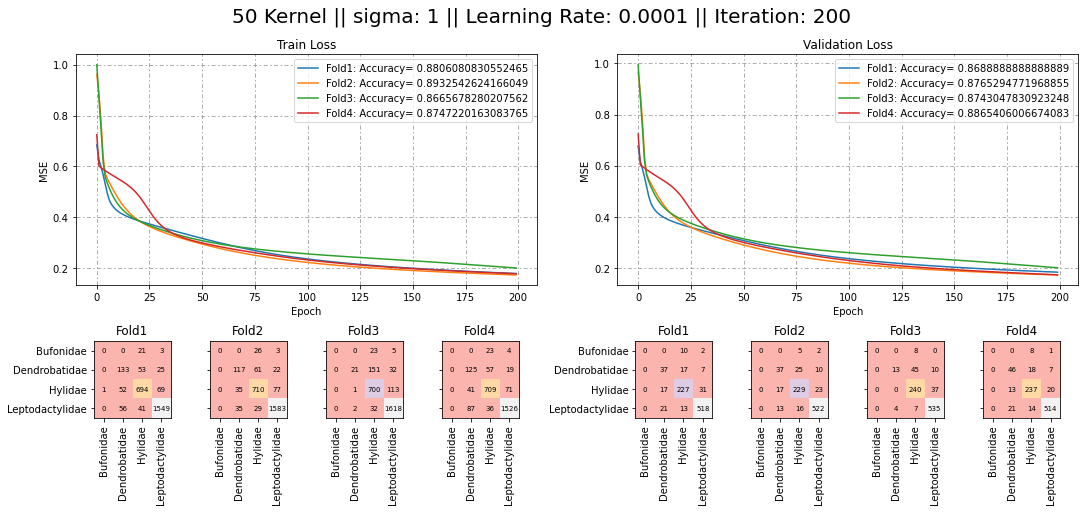

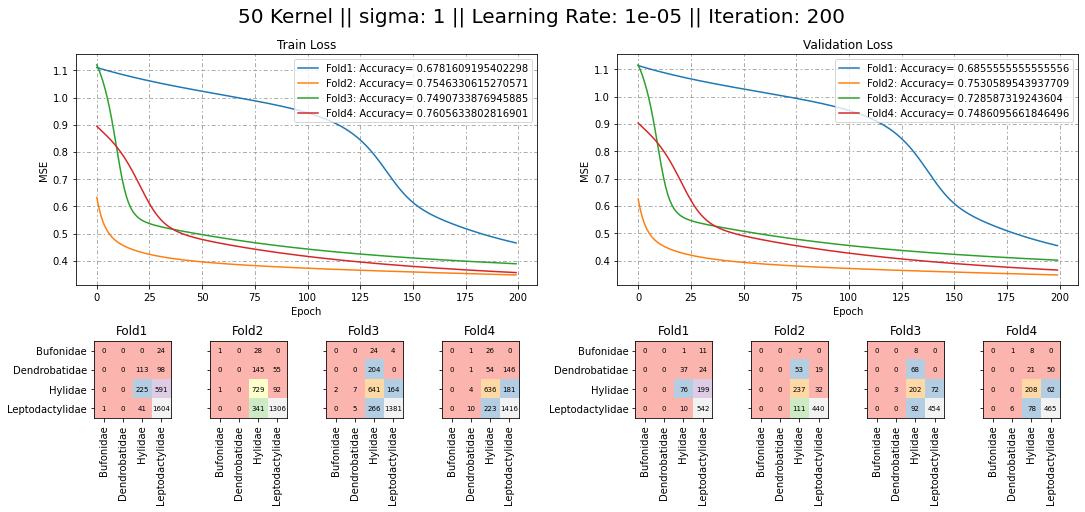

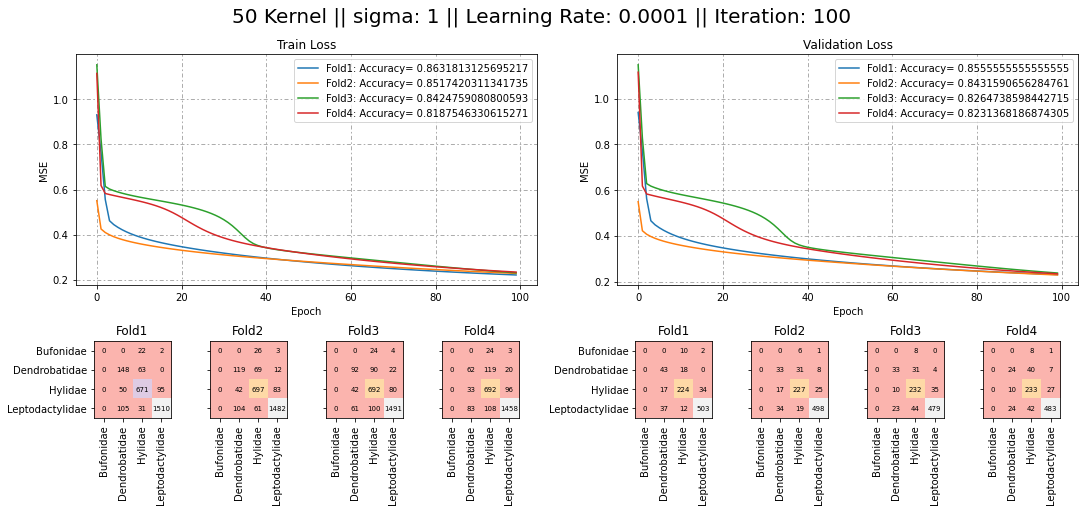

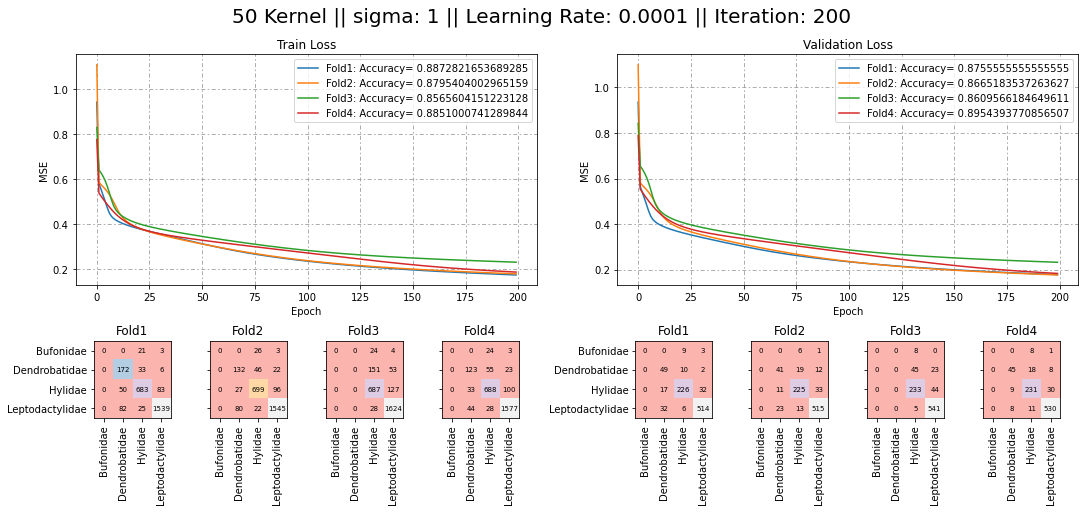

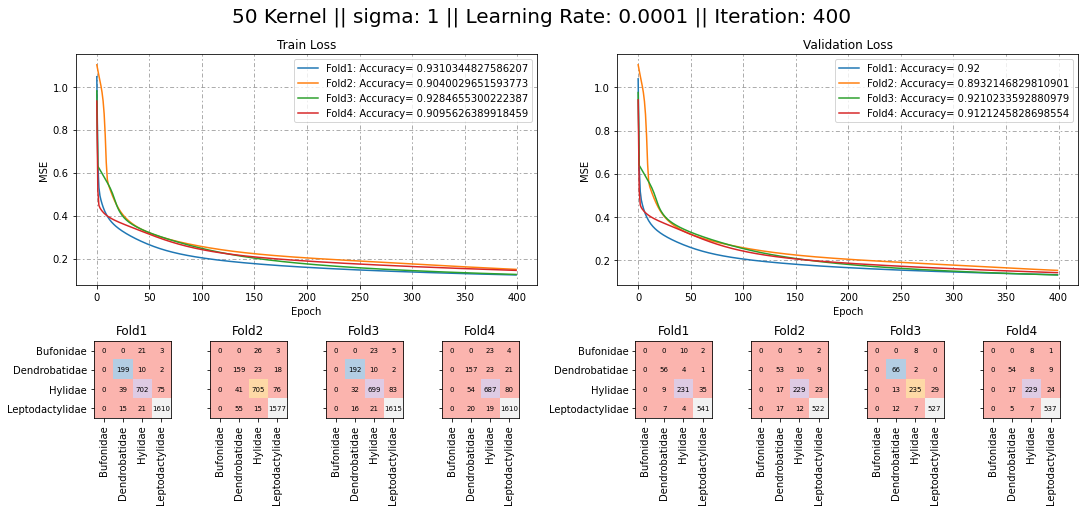

In [29]:
#showing result
labels = ['Bufonidae', 'Dendrobatidae', 'Hylidae', 'Leptodactylidae']
#iterating through different conditions
for i, condition in enumerate(conditions):
    fig = plt.figure(constrained_layout=True, figsize=(15,7))
    gs = GridSpec(4, 8, figure= fig)
    fig.suptitle(f'{condition[0]} Kernel || sigma: {condition[1]} || Learning Rate: {condition[2]} || Iteration: {condition[3]}', fontsize= 20)
    ax = [0] * 10
    
    #plot of Loss vs. Epoch for training dataset
    ax[0] = fig.add_subplot(gs[:3,:4])
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('MSE')
    ax[0].set_title('Train Loss')
    ax[0].grid(True, color='0.6', dashes=(5, 3, 2, 3))
    #plot of Loss vs. Epoch for validation dataset
    ax[1] = fig.add_subplot(gs[:3,4:])
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('MSE')
    ax[1].set_title('Validation Loss')
    ax[1].grid(True, color='0.6', dashes=(5, 3, 2, 3))
    for k in range(4):
        #training
        ax[0].plot(condition_result[i][k]['loss_train'], label= f'Fold{k+1}: Accuracy= {condition_result[i][k]["accuracy_train"][-1]}')
        #validation
        ax[1].plot(condition_result[i][k]['loss_valid'], label= f'Fold{k+1}: Accuracy= {condition_result[i][k]["accuracy_valid"][-1]}')
    ax[0].legend()
    ax[1].legend()
    
    #plot of confusion matrix in each fold
    for k in range(4):
        #training
        ax[k+2] = fig.add_subplot(gs[3,k])
        ax[k+2].imshow(condition_result[i][k]['confusion_train'], cmap="Pastel1")
        ax[k+2].set_xticks(np.arange(len(labels)))
        ax[k+2].set_yticks(np.arange(len(labels)))
        ax[k+2].set_xticklabels(labels, rotation= 90)
        ax[k+2].set_yticklabels('')
        ax[k+2].set_title(f'Fold{k+1}')
        for p in range(len(condition_result[i][k]['confusion_train'][0])):
            for q in range(len(condition_result[i][k]['confusion_train'][1])):
                ax[k+2].text(q, p, condition_result[i][k]['confusion_train'][p, q], ha="center", va="center", color="k", size= 7)
        #validation
        ax[k+6] = fig.add_subplot(gs[3,k+4])
        ax[k+6].imshow(condition_result[i][k]['confusion_valid'], cmap="Pastel1")
        ax[k+6].set_xticks(np.arange(len(labels)))
        ax[k+6].set_yticks(np.arange(len(labels)))
        ax[k+6].set_xticklabels(labels, rotation= 90)
        ax[k+6].set_yticklabels('')
        ax[k+6].set_title(f'Fold{k+1}')
        for p in range(len(condition_result[i][k]['confusion_valid'][0])):
            for q in range(len(condition_result[i][k]['confusion_valid'][1])):
                ax[k+6].text(q, p, condition_result[i][k]['confusion_valid'][p, q], ha="center", va="center", color="k", size= 7)
    ax[2].set_yticklabels(labels)
    ax[6].set_yticklabels(labels)

According to result of previous part, we choose:

70 kernrls

1 as sigmas

learning rate of 0.0001

300 iteration

for best hyper parameters. Now we put 4 fold datasets away and train on all training data. Now we use test dataset to check how well our network is classifing.

In [32]:
#selecting random initial centers
index = random.sample(range(X_train.shape[1]), 70)
cen = X_train[:, index]
#defining initial sigmas
sig = np.ones([70, 1]) * 1
#defining network
saeid = RBF_NN(d= X_train.shape[0], h= 70 ,m= Y_train.shape[0],
            C= cen, S= sig, eta= 0.0001)
#fitting on all training data
result = fit(saeid, X_train, Y_train, 300, X_test, Y_test, valid= True)

Showing final result. Left side is plot of training data and right side is plot of testing data.

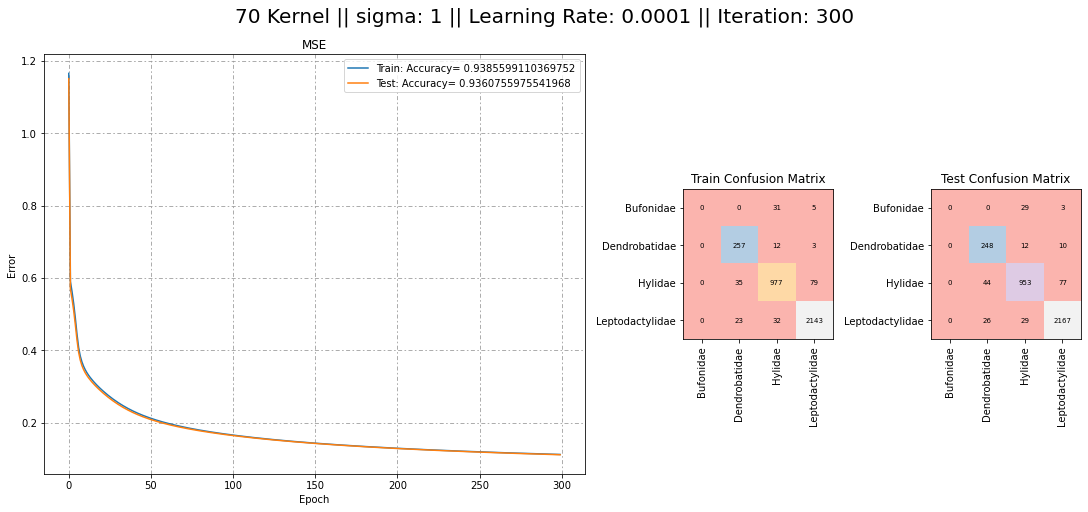

In [33]:
labels = ['Bufonidae', 'Dendrobatidae', 'Hylidae', 'Leptodactylidae']
fig = plt.figure(constrained_layout=True, figsize=(15,7))
gs = GridSpec(1, 4, figure= fig)
fig.suptitle(f'70 Kernel || sigma: 1 || Learning Rate: 0.0001 || Iteration: 300', fontsize= 20)
ax = [0] * 3

ax[0] = fig.add_subplot(gs[:2])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Error')
ax[0].set_title('MSE')
ax[0].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[0].plot(result['loss_train'], label= f'Train: Accuracy= {result["accuracy_train"][-1]}')
ax[0].plot(result['loss_valid'], label= f'Test: Accuracy= {result["accuracy_valid"][-1]}')
ax[0].legend()
    
ax[1] = fig.add_subplot(gs[2])
ax[1].imshow(result['confusion_train'], cmap="Pastel1")
ax[1].set_xticks(np.arange(len(labels)))
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_xticklabels(labels, rotation= 90)
ax[1].set_yticklabels(labels)
ax[1].set_title('Train Confusion Matrix')
for p in range(len(result['confusion_train'][0])):
    for q in range(len(result['confusion_train'][1])):
        ax[1].text(q, p, result['confusion_train'][p, q], ha="center", va="center", color="k", size= 7)
        
ax[2] = fig.add_subplot(gs[3])
ax[2].imshow(result['confusion_valid'], cmap="Pastel1")
ax[2].set_xticks(np.arange(len(labels)))
ax[2].set_yticks(np.arange(len(labels)))
ax[2].set_xticklabels(labels, rotation= 90)
ax[2].set_yticklabels(labels)
ax[2].set_title('Test Confusion Matrix')
for p in range(len(result['confusion_valid'][0])):
    for q in range(len(result['confusion_valid'][1])):
        ax[2].text(q, p, result['confusion_valid'][p, q], ha="center", va="center", color="k", size= 7)

### Part b.
Now we use "k-mean" algorithm to choose better centers for initial centers of radial basis function neural network. We try different "k" and use "elbow" method to choose the best "k".

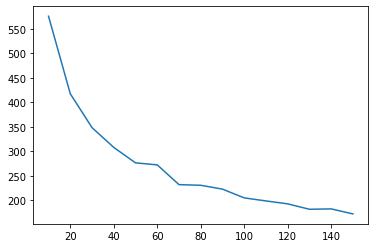

In [9]:
#different k values
k = np.arange(10, 160, 10)
distortion = np.zeros(k.shape)
for i, j in enumerate(k):
    distortion[i], _=k_mean(X_train, j, 200)
#plotting distortion vs. k
plt.plot(k, distortion)

According to the plot, k=70 is the best value for k-mean algorithm. Now we re-run k-mean algorithm and use its centers instead of random initial centers of RBF_NN.

In [35]:
#keeping centers from "k-mean"
_, cen=k_mean(X_train, 70, 200)
#initial sigmas
sig = np.ones([70, 1]) * 1
#defining network
saeid = RBF_NN(d= X_train.shape[0], h= 70 ,m= Y_train.shape[0],
            C= cen, S= sig, eta= 0.0001)
#fitting on train data
result = fit(saeid, X_train, Y_train, 300, X_test, Y_test, valid= True)

Showing final result. Left side is plot of training data and right side is plot of testing data.

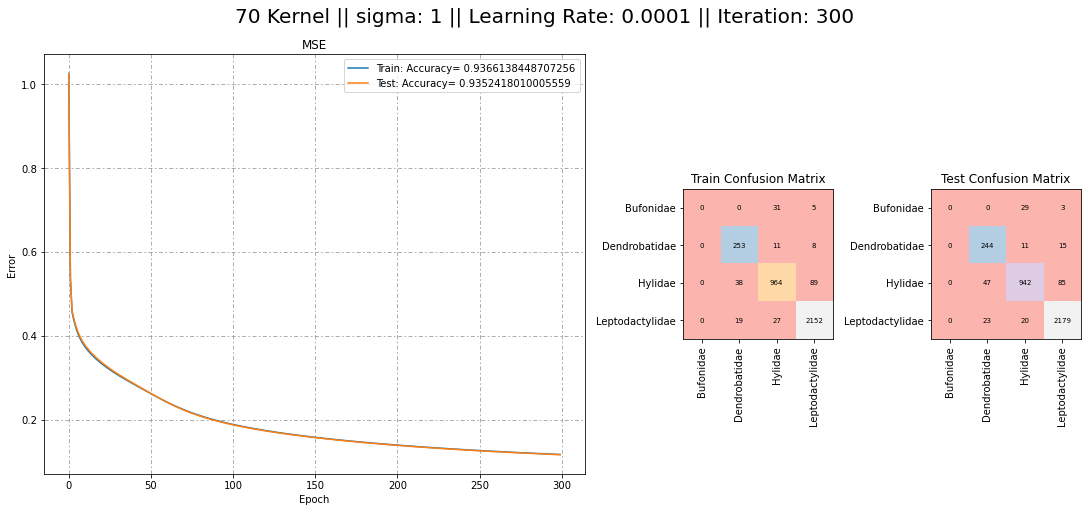

In [37]:
labels = ['Bufonidae', 'Dendrobatidae', 'Hylidae', 'Leptodactylidae']
fig = plt.figure(constrained_layout=True, figsize=(15,7))
gs = GridSpec(1, 4, figure= fig)
fig.suptitle(f'70 Kernel || sigma: 1 || Learning Rate: 0.0001 || Iteration: 300', fontsize= 20)
ax = [0] * 3

ax[0] = fig.add_subplot(gs[:2])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Error')
ax[0].set_title('MSE')
ax[0].grid(True, color='0.6', dashes=(5, 3, 2, 3))
ax[0].plot(result['loss_train'], label= f'Train: Accuracy= {result["accuracy_train"][-1]}')
ax[0].plot(result['loss_valid'], label= f'Test: Accuracy= {result["accuracy_valid"][-1]}')
ax[0].legend()
    
ax[1] = fig.add_subplot(gs[2])
ax[1].imshow(result['confusion_train'], cmap="Pastel1")
ax[1].set_xticks(np.arange(len(labels)))
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_xticklabels(labels, rotation= 90)
ax[1].set_yticklabels(labels)
ax[1].set_title('Train Confusion Matrix')
for p in range(len(result['confusion_train'][0])):
    for q in range(len(result['confusion_train'][1])):
        ax[1].text(q, p, result['confusion_train'][p, q], ha="center", va="center", color="k", size= 7)
        
ax[2] = fig.add_subplot(gs[3])
ax[2].imshow(result['confusion_valid'], cmap="Pastel1")
ax[2].set_xticks(np.arange(len(labels)))
ax[2].set_yticks(np.arange(len(labels)))
ax[2].set_xticklabels(labels, rotation= 90)
ax[2].set_yticklabels(labels)
ax[2].set_title('Test Confusion Matrix')
for p in range(len(result['confusion_valid'][0])):
    for q in range(len(result['confusion_valid'][1])):
        ax[2].text(q, p, result['confusion_valid'][p, q], ha="center", va="center", color="k", size= 7)